## Generate a single continuous-time simulation

In [1]:
import numpy as np
import math,pickle
import pandas as pd

In [2]:
import sys
if '..' not in sys.path:
    sys.path.append('..')

from lib.mobilitysim_split import MobilitySimulator
from lib.distrib import CovidDistributions
from lib.slim_dynamics import *

In [3]:
#duration of the simulation in hours
max_time= 480 #in hours

In [4]:
from lib.settings.town_settings_tubingen import *
mob_settings = '../lib/mobility/Isle_of_Wight_settings_pop10_site10.pk'  


# See town-generator.ipynb for an example on how to create the settings
with open(mob_settings, 'rb') as fp:
    obj = pickle.load(fp)
    
n_indiv=int(obj['num_people_unscaled']/obj['downsample_pop'])

All necessary distributions with parameteres from recent literature are imported

In [5]:
country = 'GBR'
distributions = CovidDistributions(country=country)

In [6]:
beta = 1.0 # this parameter enters in the conditional intensity during contacts 

#possibly different values of beta can be defined or inferred (see calibrate.py)
intensity_params = {
    'betas' : {
        'education': beta,
        'social': beta,
        'bus_stop': beta,
        'office': beta,
        'supermarket': beta}, 
    'beta_household' : beta
}

Set the initial seed of numpy 

In [7]:
# Choose random seed
c = 0
np.random.seed(c)
# Define prefix string used to save plots
runstr = f'run{c}_'

Set initial seeds of infection

In [8]:
initial_counts = {'expo': 5, 'isym': 3, 'iasy': 2} #in the form {'expo': 7, 'isym_posi': 2, 'iasy': 2}
initial_seeds=get_seeds(n_indiv, initial_counts)
initial_seeds

{'expo': [10989, 45, 10761, 9470, 7362],
 'isym': [3824, 11689, 6343],
 'iasy': [6550, 5034]}

Run the epidemic simulation

In [9]:
results = run(mob_settings, intensity_params, distributions, max_time, initial_seeds)

t: 480 | 480 hrs (20 d)
[Reached max time: 480h (20d)]


Plot aggregate results

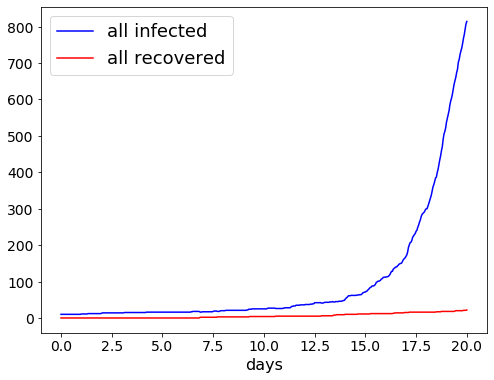

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8,6))
states=['expo','ipre','iasy','isym','hosp']
ts, val = comp_state_over_time(results, states)
plt.plot(ts, val, c='b', linestyle='-',label='all infected')
states=['resi','dead']
ts, val = comp_state_over_time(results, states)
plt.plot(ts, val, c='r', linestyle='-',label='all recovered')
plt.xlabel('days',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=18)
plt.show()

#### Extract temporal pairwise contacts (co-occurrencies in sites) with time coordinates and duration

In [11]:
cont=[]
for i in results.mob.contacts:
    for j in results.mob.contacts[i]:
        for h in results.mob.contacts[i][j]:
            cont.append((h.indiv_i,h.indiv_j,h.t_from, h.t_to, h.t_to-h.t_from))
            
contact_raw= pd.DataFrame(data=cont, columns=['indiv_i', 'indiv_j', 't_from', 't_to', 'deltat'])

contact_raw.to_csv('contacts_IsleWight.csv', index=True) 

#### Generate coarse-grained temporal contact network

Keep only contacts lasting more than $t_{res}$ (now set to 15 min) and coarse-grain them into daily contacts

In [12]:
t_res=0.25
contact_raw2=contact_raw[contact_raw['deltat']>t_res]
contact_raw2=contact_raw2.reset_index()
contact_raw2.drop(columns=['index'],inplace=True)
contact_raw2

,indiv_i,indiv_j,t_from,t_to,deltat
0,0,79,165.699811,166.181115,0.481304
1,0,79,394.830919,396.180794,1.349875
2,0,963,395.162997,396.180794,1.017797
3,0,1121,395.782116,396.180794,0.398678
4,0,2127,394.830919,395.776697,0.945778
...,...,...,...,...,...
3070279,14193,7782,368.380740,368.734494,0.353754
3070280,14193,9837,368.380740,368.734494,0.353754
3070281,14193,12023,368.380740,368.734494,0.353754
3070282,14193,13634,368.380740,368.734494,0.353754


In [13]:
t_unit = 24
period = np.arange(0,max_time+t_unit,t_unit*1.0)
print(period)

[  0.  24.  48.  72.  96. 120. 144. 168. 192. 216. 240. 264. 288. 312.
 336. 360. 384. 408. 432. 456. 480.]


In [14]:
n_contacts=len(contact_raw2)
indiv_i=contact_raw2.indiv_i.to_numpy()
indiv_j=contact_raw2.indiv_j.to_numpy()
t_from=contact_raw2.t_from.to_numpy()
t_to=contact_raw2.t_to.to_numpy()
dt=contact_raw2.deltat.to_numpy()    

In [15]:
cont_sqzd_dict={}
for i in range(n_contacts):
    mlen=int(dt[i]//t_unit)
    for s in range(mlen+1):
        a=(indiv_i[i],indiv_j[i],int(t_from[i])//t_unit +s)
        if a in cont_sqzd_dict:
            cont_sqzd_dict[a]+=(1 if s<mlen else (dt[i]/t_unit - mlen))           
        else:
            cont_sqzd_dict[a]=(1 if s<mlen else (dt[i]/t_unit - mlen))

Save contacts with individual-based daily transmission coefficients based on duration and intensity parameter $\beta$

In [16]:
cont_sqzd=[]
l=list(cont_sqzd_dict.keys())
for a in l:
    cont_sqzd+=[(a[0],a[1],a[2], 1-np.exp(-beta*cont_sqzd_dict[a]))]
    #cont_sqzd+=[(a[1],a[0],a[2], 1-np.exp(-beta*cont_sqzd_dict[a]))]  #add if contacts are not already symmetrized
    
cont2_sqzd = pd.DataFrame(cont_sqzd,columns=['i', 'j', 't', 'lambda'])
cont_sqzd_sorted=cont2_sqzd.sort_values(by=['t','i'],ascending=True)
cont_sqzd_sorted.to_csv('cont_miniIsleWight_exp.csv', index=False) 

Save contacts weighted by their temporal duration

In [17]:
cont_sqzd2=[]
l=list(cont_sqzd_dict.keys())
for a in l:
    cont_sqzd2+=[(a[0],a[1],a[2], cont_sqzd_dict[a])]
    #cont_sqzd2+=[(a[1],a[0],a[2], cont_sqzd_dict[a])]  #add if contacts are not already symmetrized
cont2_sqzd2 = pd.DataFrame(cont_sqzd2,columns=['i', 'j', 't', 'lambda'])
cont_sqzd2_sorted=cont2_sqzd2.sort_values(by=['t','i'],ascending=True)
cont_sqzd2_sorted.to_csv('cont_miniIsleWight_lin.csv', index=False) 

#### Distribution of transmission coefficient values over the edges

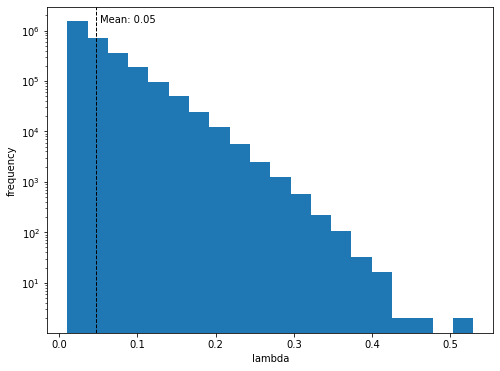

In [18]:
lamb=np.array([cont_sqzd[i][3] for i in range(len(cont_sqzd))])
plt.figure(figsize=(8,6))
plt.hist(lamb,bins=20)
plt.axvline(lamb.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(lamb.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(lamb.mean()))
plt.yscale('log')
plt.xlabel('lambda')
plt.ylabel('frequency')
plt.show()

#### Configurations mapped on $\{S,I,R\}$ states
Here the exposed state is considered an infected one. 

In [19]:
status= {'susc': 0, 'expo': 0, 'ipre': 1, 'isym': 1, 'iasy': 1, 'resi': 2, 'dead': 2, 'hosp': 1}
conf={}
max_day=max_time//t_unit
for day in range( max_day):
    t=day*TO_HOURS
    conf[day]=0*(is_state_at(results, 'susc', t)) + 1*(is_state_at(results, 'expo', t)+is_state_at(results, 'ipre', t)+is_state_at(results, 'iasy', t) \
                                                   +is_state_at(results, 'isym', t)+is_state_at(results, 'hosp', t))\
               + 2*(is_state_at(results, 'resi', t)+is_state_at(results, 'dead', t))
    
            
conf_df=pd.DataFrame(conf)
conf_df.to_csv('confs_IsleWight.csv')    

#### Recovery time distribution

In [20]:
traj={}
for i in range(results.n_people[0]):
    traj[i]=np.array([conf[day][i] for day in range(max_day)])

In [21]:
t_IR={}
for i in range(results.n_people[0]):
    t_IR[i]=np.where(traj[i][:-1] != traj[i][1:])[0]

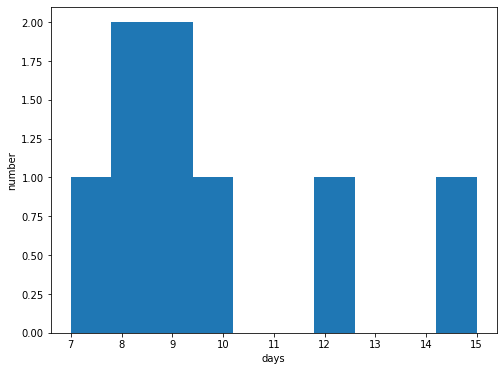

In [22]:
plt.figure(figsize=(8,6))
plt.hist([t_IR[i][1]-t_IR[i][0] for i in range(results.n_people[0]) if len(t_IR[i])==2],cumulative=False,density=False);
plt.xlabel('days')
plt.ylabel('number')
plt.show()